## Get Data

In [0]:
from google.colab import files

In [0]:
files.upload()

In [0]:
!pip install -q kaggle

In [0]:
!mkdir -p ~/.kaggle

In [0]:
!cp kaggle.json ~/.kaggle/

In [0]:
!chmod 600 /root/.kaggle/kaggle.json

In [0]:
!kaggle datasets download buntyshah/india-ml-hiring-hackathon-2019

In [0]:
!unzip "../content/india-ml-hiring-hackathon-2019.zip" 

## Read Data

In [0]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from sklearn.preprocessing import LabelEncoder
from sklearn import model_selection
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler
import lightgbm as lgb
import xgboost as xgb
from sklearn.decomposition import PCA,KernelPCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from keras import Sequential
from keras import layers
from keras import backend as K
from keras.layers.core import Dense
from keras import regularizers
from keras.layers import Dropout
from keras.constraints import max_norm
import tensorflow as tf
import keras
from lightgbm import LGBMClassifier


# Data processing, metrics and modeling
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, StratifiedKFold,KFold

from datetime import datetime
from sklearn.metrics import precision_score, recall_score, confusion_matrix, accuracy_score, roc_auc_score, f1_score, roc_curve, auc,precision_recall_curve
from sklearn import metrics
from sklearn import preprocessing

In [0]:
train = pd.read_csv("../content/train.csv")
test = pd.read_csv("../content/test.csv")
sub = pd.read_csv("../content/sample_submission.csv")

In [0]:
train['m13'].value_counts()

0    115422
1       636
Name: m13, dtype: int64

## Based on EDA

In [0]:
train = train.drop(['loan_id','number_of_borrowers'],axis=1)
test = test.drop(['loan_id','number_of_borrowers'],axis=1)

In [0]:
train.head()

,source,financial_institution,interest_rate,unpaid_principal_bal,loan_term,origination_date,first_payment_date,loan_to_value,debt_to_income_ratio,borrower_credit_score,loan_purpose,insurance_percent,co-borrower_credit_score,insurance_type,m1,m2,m3,m4,m5,m6,m7,m8,m9,m10,m11,m12,m13
0,Z,"Turner, Baldwin and Rhodes",4.250,214000,360,2012-03-01,05/2012,95,22.0,694.0,C86,30.0,0.0,0.0,0,0,0,0,0,0,1,0,0,0,0,0,1
1,Y,"Swanson, Newton and Miller",4.875,144000,360,2012-01-01,03/2012,72,44.0,697.0,B12,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,1,0,1
2,Z,Thornton-Davis,3.250,366000,180,2012-01-01,03/2012,49,33.0,780.0,B12,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,1
3,X,OTHER,4.750,135000,360,2012-02-01,04/2012,46,44.0,633.0,B12,0.0,638.0,0.0,0,0,0,0,0,0,0,0,1,1,1,1,1
4,X,OTHER,4.750,124000,360,2012-02-01,04/2012,80,43.0,681.0,C86,0.0,0.0,0.0,0,1,2,3,4,5,6,7,8,9,10,11,1


In [0]:

#test['new_feature'] = test['m1'] + test['m2'] + test['m3'] + test['m4'] + test['m5'] + test['m6'] +test['m7']+test['m8']+test['m10']+test['m11']

In [0]:
#train['new_feature'] = train['new_feature'].astype('object')
#test['new_feature'] = test['new_feature'].astype('object')

In [0]:
train['credit_score'] = train['borrower_credit_score'] + train['co-borrower_credit_score']
test['credit_score'] = test['borrower_credit_score'] + test['co-borrower_credit_score']

In [0]:
#train['total_deliquency'] = train['m1'] + train['m2'] + train['m3'] + train['m4'] + train['m5'] + train['m6'] +train['m7']+train['m8']+train['m9']+train['m10']+train['m11']+train['m12']
#test['total_deliquency'] = test['m1'] + test['m2'] + test['m3'] + test['m4'] + test['m5'] + test['m6'] +test['m7']+test['m8']+test['m9']+test['m10']+test['m11']+test['m12']

## Align Data

In [0]:
train = pd.get_dummies(train)
test = pd.get_dummies(test)

In [0]:
# Align train and test

train_labels = train['m13']

# Align the training and testing data, keep only columns present in both dataframes
train_df, test_df = train.align(test, join = 'inner', axis = 1)

# Add the target back in
train_df['m13'] = train_labels

print('Training Features shape: ', train_df.shape)
print('Testing Features shape: ', test_df.shape)

Training Features shape:  (116058, 48)
Testing Features shape:  (35866, 47)


## Over followed by Under Samping

In [0]:
from imblearn.under_sampling import TomekLinks

In [0]:
tl = TomekLinks()

In [0]:
y = train_df['m13']
X = train_df.drop('m13',axis=1)

In [0]:
from imblearn.over_sampling import SVMSMOTE

In [0]:
sm = SVMSMOTE(random_state=42)

In [0]:
X_res, y_res = sm.fit_resample(X, y)

In [0]:
from imblearn.under_sampling import AllKNN
allknn = AllKNN()

In [0]:
X_res, y_res = tl.fit_resample(X_res, y_res)

In [0]:
X_res, y_res = allknn.fit_resample(X_res, y_res)

In [0]:
print(X_res.shape , y_res.shape)

(176698, 47) (176698,)


In [0]:
y_res.sum()

63762

In [0]:
## More under sampling
from imblearn.under_sampling import NeighbourhoodCleaningRule
#ncr = NeighbourhoodCleaningRule()
#X_res, y_res = ncr.fit_resample(X_res, y_res)

In [0]:
print(X_res.shape , y_res.shape)

(176698, 47) (176698,)


In [0]:
y_res.sum()

63762

In [0]:
X_res = pd.DataFrame(X_res,columns=X.columns)

In [0]:
y_res = pd.Series(y_res)

## Light GBM

In [0]:
X_train, X_test, y_train, y_test = train_test_split(X_res, y_res, test_size=0.2, random_state=10,stratify=y_res)

In [0]:
from sklearn.metrics import f1_score

def lgb_f1_score(y_hat, data):
    y_true = data.get_label()
    y_hat = np.round(y_hat) # scikits f1 doesn't like probabilities
    return 'f1', f1_score(y_true, y_hat), True

In [0]:
def run_lgb(X_train, X_test, y_train, y_test, test_df):
    params = {
        "objective" : "binary",
       "n_estimators":10000,
       "reg_alpha" : 2.0,
       "reg_lambda":2.1,
       "n_jobs":-1,
       "colsample_bytree":.8,
       "min_child_weight":0.8,
       "subsample":0.8715623,
       "min_data_in_leaf":20,
       "nthread":4,
       "metric" : "f1",
       "num_leaves" : 100,
       "learning_rate" : 0.01,
       "verbosity" : -1,
       "seed": 120,
       "max_bin":60,
       'max_depth':15,
       'min_gain_to_split':.0222415,
       'scale_pos_weight':1
    }
    
    lgtrain = lgb.Dataset(X_train, label=y_train)
    lgval = lgb.Dataset(X_test, label=y_test)
    evals_result = {}
    model = lgb.train(params, lgtrain, 10000, 
                      valid_sets=[lgtrain, lgval], 
                      early_stopping_rounds=100, 
                      verbose_eval=100, 
                      evals_result=evals_result,feval=lgb_f1_score)
    
    pred_test_y = model.predict(test_df, num_iteration=model.best_iteration)
    return pred_test_y, model, evals_result

In [0]:
pred_test, model, evals_result = run_lgb(X_train, X_test, y_train, y_test, test_df)
print("LightGBM Training Completed...")

/usr/local/lib/python3.6/dist-packages/lightgbm/engine.py:118: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


Training until validation scores don't improve for 100 rounds.
[100]	training's f1: 0.995433	valid_1's f1: 0.995565
[200]	training's f1: 0.995877	valid_1's f1: 0.995763
Early stopping, best iteration is:
[117]	training's f1: 0.995799	valid_1's f1: 0.995921
LightGBM Training Completed...


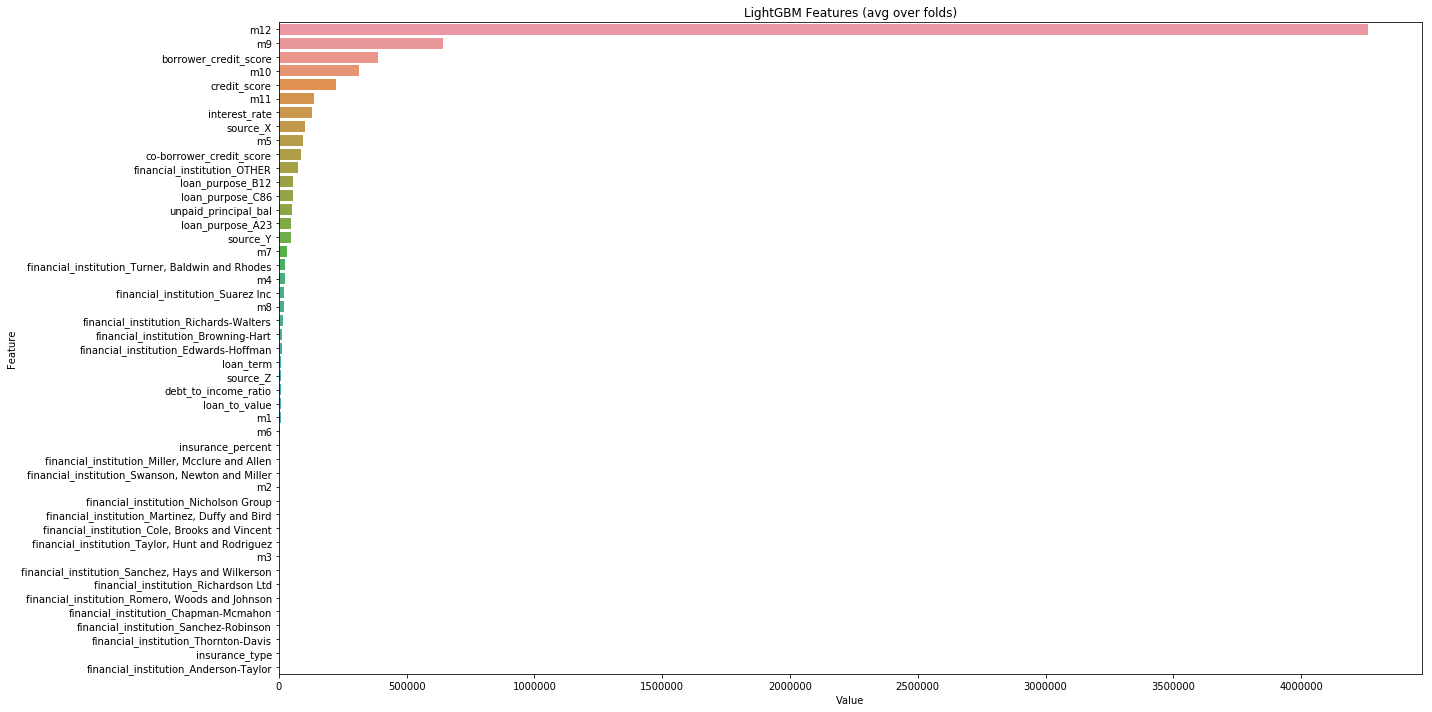

In [0]:
feature_imp = pd.DataFrame(sorted(zip(model.feature_importance(),X_train.columns)), columns=['Value','Feature'])
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# sorted(zip(clf.feature_importances_, X.columns), reverse=True)
feature_imp = pd.DataFrame(sorted(zip(model.feature_importance(importance_type='gain'),X_train.columns)), columns=['Value','Feature'])

plt.figure(figsize=(20, 10))
sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False).head(50))
plt.title('LightGBM Features (avg over folds)')
plt.tight_layout()
plt.show()

In [0]:
sub['m13'] = pred_test

In [0]:
sub['m13'] = sub['m13'].apply(lambda x : 1 if (x>=0.40) else 0)

In [0]:
sub['m13'].sum()

77

In [0]:
sub.to_csv('Final_R20_NewF.csv',index=False)

## Kfold LGB

In [0]:
!pip install CatBoost

In [0]:
from catboost import CatBoostClassifier

In [0]:
params = {
        "objective" : "binary",
       "n_estimators":10000,
       "reg_alpha" : 2.0,
       "reg_lambda":2.1,
       "n_jobs":-1,
       "colsample_bytree":.8,
       "min_child_weight":0.8,
       "subsample":0.8715623,
       "min_data_in_leaf":20,
       "nthread":4,
       "metric" : "f1",
       "num_leaves" : 100,
       "learning_rate" : 0.01,
       "verbosity" : -1,
       "seed": 120,
       "max_bin":60,
       'max_depth':15,
       'min_gain_to_split':.0222415,
       'scale_pos_weight':1
    }

In [0]:
from sklearn.metrics import accuracy_score,confusion_matrix,roc_auc_score
errcb=[]
y_pred_totcb=[]
from sklearn.model_selection import KFold,StratifiedKFold
fold=StratifiedKFold(n_splits=4,shuffle=True,random_state=1994)
i=1
for train_index, test_index in fold.split(X,y):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y[train_index], y[test_index]
    lgtrain = lgb.Dataset(X_train, label=y_train)
    lgval = lgb.Dataset(X_test, label=y_test)
    model = lgb.train(params, lgtrain, 10000, 
                      valid_sets=[lgtrain, lgval], 
                      early_stopping_rounds=100, 
                      verbose_eval=100,feval=lgb_f1_score)
    preds = model.predict(X_test, num_iteration=model.best_iteration)
    print("err: ",roc_auc_score(y_test,preds))
    errcb.append(roc_auc_score(y_test,preds))
    p = model.predict(test_df, num_iteration=model.best_iteration)
    y_pred_totcb.append(p)

In [0]:
y_pred_totcb

In [0]:
y_pred = np.mean(y_pred_totcb,0)

In [0]:
sub['m13'] = y_pred

In [0]:
sub['m13'] = sub['m13'].apply(lambda x : 1 if (x>=0.40) else 0)

In [0]:
sub['m13'].sum()

In [0]:
sub.to_csv('Kfold.csv',index=False)